## Experiments: Scalability Series Length RSAST

In [2]:
import sys 
import os 
#add sast library path
file_path = os.path.dirname(os.getcwd())+"/sast"

#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.path.dirname(os.getcwd())+"\sast"


#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"/sast"


#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"\sast"


#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

#add cd_diagram library path
file_path = os.path.dirname(os.getcwd())+"\cd_diagram"

#file_path = r"C:\Users\Public\random_sast\cd_diagram"
sys.path.append(file_path)


file_path = os.path.dirname(os.getcwd())+"/cd_diagram"
#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"\cd_diagram"
#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"/cd_diagram"
#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

sys.path


['c:\\Users\\Nicolas R\\random_sast\\ExperimentationRSAST',
 'c:\\ProgramData\\Anaconda3\\python39.zip',
 'c:\\ProgramData\\Anaconda3\\DLLs',
 'c:\\ProgramData\\Anaconda3\\lib',
 'c:\\ProgramData\\Anaconda3',
 '',
 'C:\\Users\\Nicolas R\\AppData\\Roaming\\Python\\Python39\\site-packages',
 'c:\\ProgramData\\Anaconda3\\lib\\site-packages',
 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Nicolas R\\.ipython',
 'c:\\Users\\Nicolas R\\random_sast/sast',
 'c:\\Users\\Nicolas R\\random_sast\\sast',
 'c:\\Users\\Nicolas R\\random_sast\\ExperimentationRSAST/sast',
 'c:\\Users\\Nicolas R\\random_sast\\ExperimentationRSAST\\sast',
 'c:\\Users\\Nicolas R\\random_sast\\cd_diagram',
 'c:\\Users\\Nicolas R\\random_sast/cd_diagram',
 'c:\\Users\\Nicolas R\\random_sast\\Experimentation

### Overall analysis

In [4]:
import time 
import os 
import gc
import numpy as np

import sys
sys.path.append(os.path.abspath("."))

from utils_sast import *
from sast import *

from sklearn.linear_model import RidgeClassifierCV,RidgeClassifier

from sast import from_2d_array_to_nested
from sktime.classification.kernel_based import RocketClassifier
#from sktime.transformations.panel.shapelets import *

from sktime.datasets import load_UCR_UEA_dataset
from matplotlib.ticker import FuncFormatter
#from convst.classifiers import R_DST_Ridge
from aeon.classification.shapelet_based import RDSTClassifier

In [ ]:


dataset_folder = '/home/local.isima.fr/mimbouop/Univariate_arff' # the folder containing the datasets
ds = 'HouseTwenty' # the dataset to use



#max_exponent = 10 # go up to series of length 2^max_exponent
max_exponent = 10 # go up to series of length 2^max_exponent


X_train_all, y_train = load_UCR_UEA_dataset(name=ds, extract_path='data', split="train", return_type="numpy2d")
X_test_all, y_test_all = load_UCR_UEA_dataset(name=ds, extract_path='data', split="test", return_type="numpy2d")
    
# fill na
#train_ds.fillna(0, axis=1, inplace=True)
#test_ds.fillna(0, axis=1, inplace=True)

#X_train_all, y_train = format_dataset(train_ds, shuffle=True)
#X_test_all, y_test_all = format_dataset(test_ds)

df_result = {}
list_score = []
list_time_fit = []
list_time_test = []
list_dataset = []
list_hyperparameter = []
list_method = []
list_rpoint = []
list_nb_per_class = []
list_series_length = []
list_exp_length = []

for i in range(4, max_exponent+1):

    series_length = 2**i

    X_train = X_train_all[:,:series_length]
    X_test = X_test_all[:X_train.shape[0], :series_length]
    y_test = y_test_all[:X_train.shape[0]]

    max_shp_length = X_train.shape[1]

    

    print("--series_length: 2^"+str(i))

    p=10
    k=1
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifier()
    #clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    p=30
    k=1
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifier()
    #clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    p=10
    k=10
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifier()
    #clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    p=30
    k=10
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifier()
    #clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))


    print("ROCKET: kernels=10_000")

    clf = RidgeClassifier()

    start = time.time()
    trf = Rocket(num_kernels=10_000) 
    trf.fit(from_2d_array_to_nested(X_train))
    X_train_tranf = trf.transform(from_2d_array_to_nested(X_train)) 
    clf.fit(X_train_tranf,y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    X_test_tranf = trf.transform(from_2d_array_to_nested(X_test)) 
    score=clf.score(X_test_tranf,y_test)
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ROCKET: num_kernels=10_000")
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("Rocket")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    k=1
    
    #candidate_lengths = np.arange(min_shp_length, max_shp_length+1)
    clf = RidgeClassifier()
    min_shp_length = 3
    max_shp_length = X_train.shape[1]
    candidate_lengths = np.arange(3, max_shp_length)
    min_shp_length = min(candidate_lengths)
    max_shp_length = max(candidate_lengths)
    print("SAST: min_shapelet_length="+str(min_shp_length)+" max_shapelet_length=m")
    start = time.time()
    

    random_state = None
    

    sast_ridge = SAST(cand_length_list=candidate_lengths,
                            nb_inst_per_class=k, 
                             classifier=clf)

    sast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=sast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("SAST: min_shapelet_length="+str(min_shp_length)+" max_shapelet_length=m")
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("SAST")  
    list_series_length.append(series_length)
    list_exp_length.append(str(i))
    
    
    print("RDST: n_shapelets=10_000")

    X_train_rdst=X_train[:, np.newaxis, :]
    y_train_rdst=np.asarray([int(x_s) for x_s in y_train])

    X_test_rdst=X_test[:, np.newaxis, :]
    y_test_rdst=np.asarray([int(x_s) for x_s in y_test])

    start = time.time()

    rdst = RDSTClassifier()
    rdst.fit(X_train_rdst, y_train_rdst)
    end = time.time()
    time_fit=end-start
    start = time.time()
    score=rdst.score(X_test_rdst, y_test_rdst)
    end = time.time()
    time_test=end-start
    
    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("RDST: n_shapelets=10_000")
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("RDST")  
    list_series_length.append(series_length)
    list_exp_length.append(str(i))
    
    '''
    min_shp_length = 3
    print("STC: min_shapelet_length="+str(min_shp_length)+" max_shapelet_length="+str(np.inf))
    
    max_shp_length = X_train.shape[1]
    start = time.time()
    #Creating a ShapeletTransform and fitting
    st = ShapeletTransform(min_shapelet_length=min_shp_length, max_shapelet_length=np.inf)
    X_train_sktime = from_2d_array_to_nested(pd.DataFrame(X_train))
    X_test_sktime = from_2d_array_to_nested(pd.DataFrame(X_test))
    st.fit(X_train_sktime, y_train)
    #Making the tranformation of time series and training a RandomForestClassifier model
    X_test_transformed = st.transform(X_test_sktime)
    X_train_transformed = st.transform(X_train_sktime)
    clf = RandomForestClassifier()
    clf.fit(X_train_transformed, y_train)
    
    end = time.time()
    list_score.append(clf.score(X_test_transformed, y_test))
    list_time.append(end-start)
    list_dataset.append(ds)
    list_hyperparameter.append("min_shapelet_length="+str(min_shp_length)+" max_shapelet_length="+str(max_shp_length))
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("STC")  
    '''
    
    

df_result['accuracy']=list_score
df_result['time_fit']=list_time_fit
df_result['time_test']=list_time_test
df_result['dataset_name']=list_dataset
df_result['hyperparameter']=list_hyperparameter
df_result['rpoint']=list_rpoint
df_result['nb_per_class']=list_nb_per_class
df_result['classifier_name']=list_method
df_result['series_length']=list_series_length
df_result['exp_length']=list_exp_length

df_result=pd.DataFrame(df_result)
# export a overall dataset with the comparison
df_result.to_csv("results_comparison_accuracy/df_overall_comparison_scalability_series_length.csv")
    #  Write results
    #result = [series_length, sast_time_fit, sast_time_test, sast_fixed_time_fit, sast_fixed_time_test, saste_time_fit, saste_time_test, saste_fixed_time_fit, saste_fixed_time_test, stc_time_fit, stc_time_test]
    #f.write(','.join(np.array(result, dtype=np.str)) + '\n')

print('--All done')


--series_length: 2^4
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:50
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:19
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:340
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=10
total kernels:345
ROCKET: kernels=10_000
SAST: min_shapelet_length=3 max_shapelet_length=m
RDST: n_shapelets=10_000
--series_length: 2^5
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:130
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:177
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:530
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=10
total kernels:1608
ROCKET: kernels=10_000
SAST: min_shapelet_length=3 max_shapelet_length=m
RDST: n_shapelets=10_000
--series_length: 2^6
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:220
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:390
RSAST AC

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.76792e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


ROCKET: kernels=10_000
SAST: min_shapelet_length=3 max_shapelet_length=m


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.05658e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RDST: n_shapelets=10_000
--series_length: 2^7
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:370
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:3330


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.67193e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:5438


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.45722e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=10
total kernels:19380


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


ROCKET: kernels=10_000
SAST: min_shapelet_length=3 max_shapelet_length=m


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RDST: n_shapelets=10_000
--series_length: 2^8
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:650


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.17613e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:2700


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.56799e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:8500


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=10
total kernels:18630


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


ROCKET: kernels=10_000
SAST: min_shapelet_length=3 max_shapelet_length=m


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.02193e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RDST: n_shapelets=10_000
--series_length: 2^9
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:510
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:1620


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.62671e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:7180


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=10
total kernels:26520


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


ROCKET: kernels=10_000


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.67091e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


SAST: min_shapelet_length=3 max_shapelet_length=m


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RDST: n_shapelets=10_000
--series_length: 2^10
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=1
total kernels:2220


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:4410


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:30800


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=10
total kernels:79320


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.70942e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


ROCKET: kernels=10_000


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.9813e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


SAST: min_shapelet_length=3 max_shapelet_length=m


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.02889e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


RDST: n_shapelets=10_000
--All done


In [8]:
df_result=pd.read_csv("results_comparison_accuracy/df_overall_comparison_scalability_series_length.csv")
df_result=df_result[~df_result["hyperparameter"].isin(["ACF&PACF: n_random_points=30 nb_inst_per_class=10"])]



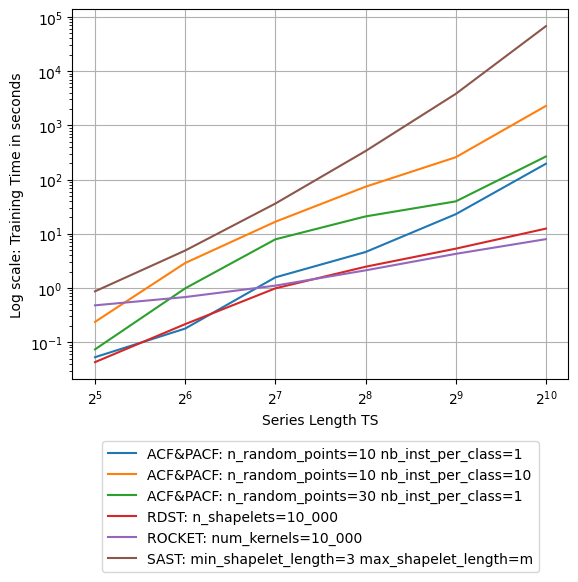

In [9]:

df_result["log_series_length"]=np.log2(df_result["series_length"])
df_result_pv=df_result[df_result["log_series_length"].isin([5,6,7,8,9,10])]
df_result_pv.pivot_table(values="time_fit", index="log_series_length", columns="hyperparameter").plot.line(grid=True, xlabel="Series Length TS", ylabel="Log scale: Training Time in seconds")


#place legend in center right of plot
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

# Define the custom formatter function
def exponent_of_2(x, pos):
    return r'$2^{{{}}}$'.format(int(x))



# Set the x-axis formatter as the custom formatter function
plt.gca().xaxis.set_major_formatter(FuncFormatter(exponent_of_2))
plt.yscale("log")  

In [5]:
df_result
df_result[df_result["hyperparameter"].isin(["ACF&PACF: n_random_points=10 nb_inst_per_class=10"])]
#df_result[df_result["hyperparameter"].isin(["ROCKET: num_kernels=10_000"])]
#df_result[df_result["hyperparameter"].isin(["SAST: min_shapelet_length=3 max_shapelet_length=m"])]
#df_result[df_result["hyperparameter"].isin(["RDST: n_shapelets=10_000"])]

,Unnamed: 0,accuracy,time_fit,time_test,dataset_name,hyperparameter,rpoint,nb_per_class,classifier_name,series_length,exp_length,log_series_length
2,2,0.325,0.097153,0.048315,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,16,4,4.0
9,9,0.675,0.237338,0.203488,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,32,5,5.0
16,16,0.450,2.889991,2.728716,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,64,6,6.0
23,23,0.450,16.673888,15.831869,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,128,7,7.0
30,30,0.875,73.827321,57.680809,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,256,8,8.0
37,37,0.850,257.927148,110.532539,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,512,9,9.0
44,44,0.750,2281.960830,1219.829672,HouseTwenty,ACF&PACF: n_random_points=10 nb_inst_per_class=10,10,10,RSAST ACF&PACF,1024,10,10.0
